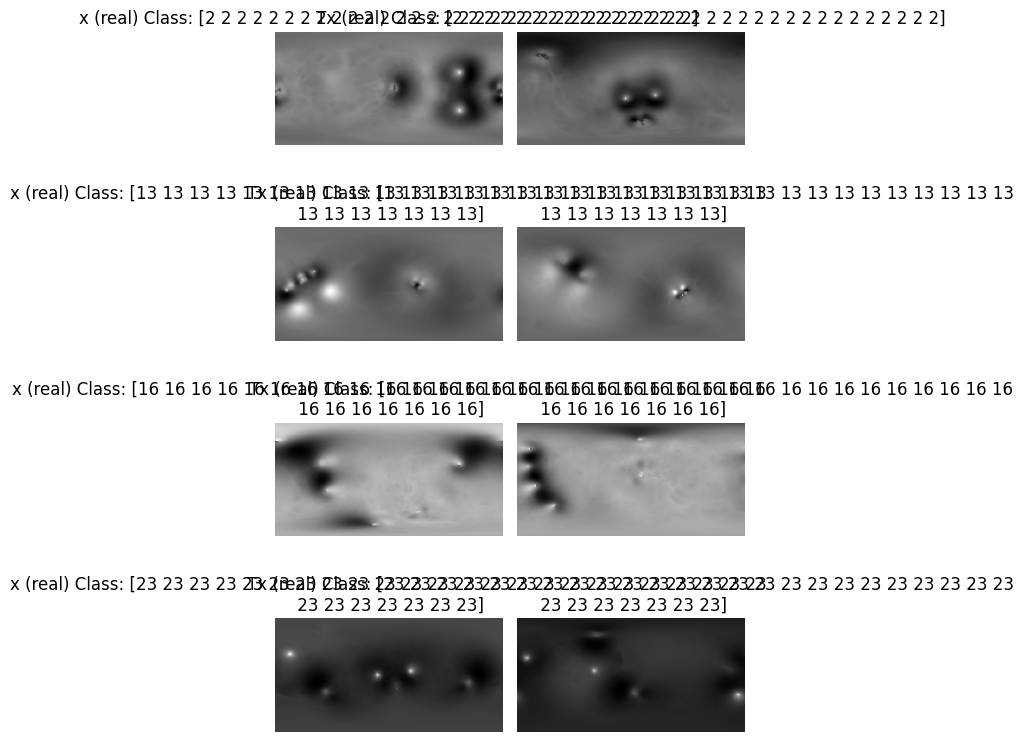

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import os
from data.input_pipeline import get_cshrec11
from data.xforms import draw_shrec11_pairs

# Set the path to your SHREC11 dataset directory
CSHREC11_DIR = "./data/SHREC_11/processed/"  # <-- Change this to your actual path if needed

# Load train data (tf.data.Dataset)
train_data, test_data, num_classes, (mean, std) = get_cshrec11(CSHREC11_DIR)

# Get a batch of real data
BATCH_SIZE = 4
NUM_SHAPES = 8  # number of shapes per batch (sequence length)

# tf.data pipeline: get a batch as numpy array
for batch in train_data.batch(NUM_SHAPES).take(1):
    # batch is a dict; get the main shape/image tensor (usually 'image', 'shape', or similar)
    # Try common keys
    for key in ['image', 'shape', 'data']:
        if key in batch:
            data = batch[key].numpy()
            break
    else:
        # fallback: just use the first key
        data = list(batch.values())[0].numpy()
    # Reshape for compatibility: (batch_size, num_shapes, H, W, C)
    data = np.expand_dims(data, axis=0) if data.ndim == 4 else data  # (N, H, W, C)
    if data.shape[0] < BATCH_SIZE:
        data = np.tile(data, (BATCH_SIZE // data.shape[0] + 1, 1, 1, 1, 1))[:BATCH_SIZE]
    break

# JAX random key
test_key = jax.random.PRNGKey(0)

# Draw pairs
pairs = draw_shrec11_pairs(jnp.array(data), test_key)

# Visualize a few pairs (x, Tx)
num_pairs_to_show = min(4, pairs.shape[0] // 2)
fig, axes = plt.subplots(num_pairs_to_show, 2, figsize=(5, 2 * num_pairs_to_show))
labels = batch.get('label', None)
for i in range(num_pairs_to_show):
    x = pairs[2*i, ...].squeeze()
    Tx = pairs[2*i+1, ...].squeeze()
    label_str = f"Class: {labels[2*i].numpy()}" if labels is not None else ""
    axes[i, 0].imshow(x[..., 0], cmap='gray')
    axes[i, 0].set_title(f'x (real) {label_str}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(Tx[..., 0], cmap='gray')
    axes[i, 1].set_title(f'Tx (real) {label_str}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()
